# Using a Deep Neural Network for Quark Tagging

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PhysData/course/blob/main/docs/notebooks/tabular_dnn.ipynb)

In this notebook, we're going to explore the use of Deep Neural Networks (DNN) in particle physics, particularly in the task of quark tagging. The goal of this notebook is to create a simple model that can classify whether a jet represents a top-quark signal or a quark-gluon background.

The dataset used in this notebook is the open-source [Top Quark Tagging](https://huggingface.co/datasets/dl4phys/top_tagging) dataset produced from simulations of proton-proton collisions.

In [1]:
from datasets import load_dataset
from fastai.tabular.all import *
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score, auc, roc_curve

## Downloading the dataset

First, let's download and inspect the dataset.

In [ ]:
# If you're running this in Colab, uncomment the next line to download the dataset.
top_tagging_ds = load_dataset("dl4phys/top_tagging")

In [3]:
top_tagging_ds

DatasetDict({
    train: Dataset({
        features: ['E_0', 'PX_0', 'PY_0', 'PZ_0', 'E_1', 'PX_1', 'PY_1', 'PZ_1', 'E_2', 'PX_2', 'PY_2', 'PZ_2', 'E_3', 'PX_3', 'PY_3', 'PZ_3', 'E_4', 'PX_4', 'PY_4', 'PZ_4', 'E_5', 'PX_5', 'PY_5', 'PZ_5', 'E_6', 'PX_6', 'PY_6', 'PZ_6', 'E_7', 'PX_7', 'PY_7', 'PZ_7', 'E_8', 'PX_8', 'PY_8', 'PZ_8', 'E_9', 'PX_9', 'PY_9', 'PZ_9', 'E_10', 'PX_10', 'PY_10', 'PZ_10', 'E_11', 'PX_11', 'PY_11', 'PZ_11', 'E_12', 'PX_12', 'PY_12', 'PZ_12', 'E_13', 'PX_13', 'PY_13', 'PZ_13', 'E_14', 'PX_14', 'PY_14', 'PZ_14', 'E_15', 'PX_15', 'PY_15', 'PZ_15', 'E_16', 'PX_16', 'PY_16', 'PZ_16', 'E_17', 'PX_17', 'PY_17', 'PZ_17', 'E_18', 'PX_18', 'PY_18', 'PZ_18', 'E_19', 'PX_19', 'PY_19', 'PZ_19', 'E_20', 'PX_20', 'PY_20', 'PZ_20', 'E_21', 'PX_21', 'PY_21', 'PZ_21', 'E_22', 'PX_22', 'PY_22', 'PZ_22', 'E_23', 'PX_23', 'PY_23', 'PZ_23', 'E_24', 'PX_24', 'PY_24', 'PZ_24', 'E_25', 'PX_25', 'PY_25', 'PZ_25', 'E_26', 'PX_26', 'PY_26', 'PZ_26', 'E_27', 'PX_27', 'PY_27', 'PZ_27', 'E_28'

In [4]:
top_tagging_ds["train"]

Dataset({
    features: ['E_0', 'PX_0', 'PY_0', 'PZ_0', 'E_1', 'PX_1', 'PY_1', 'PZ_1', 'E_2', 'PX_2', 'PY_2', 'PZ_2', 'E_3', 'PX_3', 'PY_3', 'PZ_3', 'E_4', 'PX_4', 'PY_4', 'PZ_4', 'E_5', 'PX_5', 'PY_5', 'PZ_5', 'E_6', 'PX_6', 'PY_6', 'PZ_6', 'E_7', 'PX_7', 'PY_7', 'PZ_7', 'E_8', 'PX_8', 'PY_8', 'PZ_8', 'E_9', 'PX_9', 'PY_9', 'PZ_9', 'E_10', 'PX_10', 'PY_10', 'PZ_10', 'E_11', 'PX_11', 'PY_11', 'PZ_11', 'E_12', 'PX_12', 'PY_12', 'PZ_12', 'E_13', 'PX_13', 'PY_13', 'PZ_13', 'E_14', 'PX_14', 'PY_14', 'PZ_14', 'E_15', 'PX_15', 'PY_15', 'PZ_15', 'E_16', 'PX_16', 'PY_16', 'PZ_16', 'E_17', 'PX_17', 'PY_17', 'PZ_17', 'E_18', 'PX_18', 'PY_18', 'PZ_18', 'E_19', 'PX_19', 'PY_19', 'PZ_19', 'E_20', 'PX_20', 'PY_20', 'PZ_20', 'E_21', 'PX_21', 'PY_21', 'PZ_21', 'E_22', 'PX_22', 'PY_22', 'PZ_22', 'E_23', 'PX_23', 'PY_23', 'PZ_23', 'E_24', 'PX_24', 'PY_24', 'PZ_24', 'E_25', 'PX_25', 'PY_25', 'PZ_25', 'E_26', 'PX_26', 'PY_26', 'PZ_26', 'E_27', 'PX_27', 'PY_27', 'PZ_27', 'E_28', 'PX_28', 'PY_28', 'PZ_28', 

In [5]:
len(top_tagging_ds["train"])

1211000

In [3]:
top_tagging_ds = top_tagging_ds.remove_columns(
    ["truthE", "truthPX", "truthPY", "truthPZ", "ttv"]
)

In [51]:
# Convert output format to DataFrames
top_tagging_ds.set_format("pandas")
# Create DataFrames for the training and test splits
train_df, test_df = top_tagging_ds["train"][:], top_tagging_ds["test"][:]
# Peek at first few rows
# train_df.head()

In [8]:
train_df.shape

(1211000, 801)

For demonstration purposes, we're going to restrict our dataset to the first few columns so that you can quickly run this notebook locally. If you want to use the full dataset, do not run the next cell and change `train_df_subset` to `train_df` in the rest of the notebook.

In [48]:
train_df_subset = train_df.T[0:5].T
test_df_subset = test_df.T[0:5].T

Let's print out the first few rows and columns of this dataset.

In [46]:
train_df_subset.head()

,E_0,PX_0,PY_0,PZ_0,E_1
17825,593.425598,10.976164,-254.818314,535.818176,250.897110
104211,240.854858,189.453262,97.291901,-112.484741,116.682274
337084,100.170258,-90.543556,-38.678379,-18.437143,84.275269
299097,851.673096,58.543289,256.335388,810.069092,135.725677
875065,109.890381,-97.126312,-48.310047,17.564585,107.755638


## FastAI DataLoaders

FastAI is a library for manipulating data and building AI models. You don't need a thorough understanding of this library to appreciate the use of AI for this particular task, but we highly encourage interested readers to explore further.

In the next cell, we're going to use a `DataLoader` to load our dataset to the fastai format. This will do a number of important things for us like batch splitting, an important part of data preprocessing in machine learning tasks.

In essence, our model is going to receive "batches" of training data that have just the right size so that they can fit into our computer memory. It wouldn't make sense to pass the entire dataset to our model all at once, simply because the dataset might be too large. By creating batches, we can take advantage of parallel processing units (such as those in GPUs) as well as shuffle our data around so that the model needs to learn from sparse samples at each given iteration.

In [ ]:
frac_of_samples = 1.0
train_df = train_df.sample(int(frac_of_samples * len(train_df)), random_state=42)

# features = list(train_df.drop(columns=["is_signal_new"]).columns)
features = list(train_df.columns)
splits = RandomSplitter(valid_pct=0.20, seed=42)(range_of(train_df))

dls = TabularDataLoaders.from_df(
    df=train_df,
    cont_names=features,
    y_names="is_signal_new",
    y_block=CategoryBlock,
    splits=splits,
    bs=1024,
)

## The Deep Neural Network Model

In this section, we define the neural network using the `tabular_learner` function from FastAI. You can see the individual layers and their sizes below `learn.summary()`.

In [37]:
learn = tabular_learner(
    dls, layers=[200, 200, 50, 50], metrics=[accuracy, RocAucBinary()]
)

The `tabular_learner` creates a deep neural network (DNN) with the layers specified according to the function parameters. Here we are building a network with 4 layers with the following number of nodes: 200, 200, 50, 50 respectively. We also specify that with this model, we are interested in its accuracy (i.e. how accurate is it at predicting a given jet represents a top-quark or a quark-gluon) and the metric to measure the accuracy is `RocAucBinary`. `RocAucBinary` is used for binary classification tasks such as this one and it is a measure of sensitivity of the true and false positive rate of prediction. For more information, see the following [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score).

In [38]:
learn.summary()

TabularModel (Input shape: 1024 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 800          
BatchNorm1d                               1600       True      
____________________________________________________________________________
                     1024 x 200          
Linear                                    160000     True      
ReLU                                                           
BatchNorm1d                               400        True      
Linear                                    40000      True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     1024 x 50           
Linear                                    10000      True      
ReLU                                                           
BatchNorm1d                               1

## Finding learning rate

The learning rate sets the relative size of the learning steps that the model is taking during training, i.e. how much are the model's internal parameters changed every time it gets feedback on its predictions.

SuggestedLRs(valley=0.0012022644514217973)

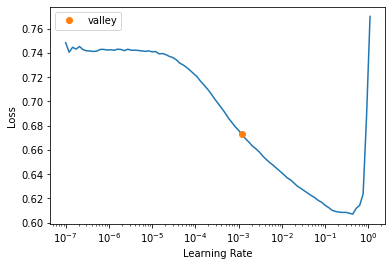

In [39]:
learn.lr_find()

## Training the model

Here we're going to run one training cycle which is going to go through all the training data. If you're running this notebook youself, consider changing the number of epochs or learning rate.

In [13]:
learn.fit_one_cycle(n_epoch=3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.516639,0.510640,0.733774,0.808236,04:35
1,0.425046,0.409908,0.806115,0.889215,03:42
2,0.382294,0.373090,0.830888,0.907570,03:09


In [ ]:
# You can inspect the results by uncommenting the following line
# learn.show_results()

## Model Evaluation

In [15]:
test_dl = learn.dls.test_dl(test_items=test_df)

In [ ]:
preds, targs = learn.get_preds(dl=test_dl)

In [17]:
preds[:5], targs[:5]

(tensor([[0.9989, 0.0011],
         [0.7789, 0.2211],
         [0.9449, 0.0551],
         [0.3912, 0.6088],
         [0.9609, 0.0391]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0]], dtype=torch.int8))

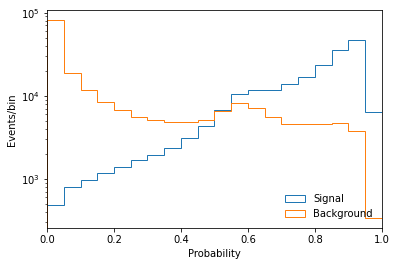

In [18]:
signal_test = preds[:, 1][targs.flatten() == 1].numpy()
background_test = preds[:, 1][targs.flatten() == 0].numpy()

plt.hist(signal_test, histtype="step", bins=20, range=(0, 1), label="Signal")
plt.hist(background_test, histtype="step", bins=20, range=(0, 1), label="Background")
plt.xlabel("Probability")
plt.ylabel("Events/bin")
plt.yscale("log")
plt.xlim(0, 1)
plt.legend(loc="lower right", frameon=False)
plt.show()

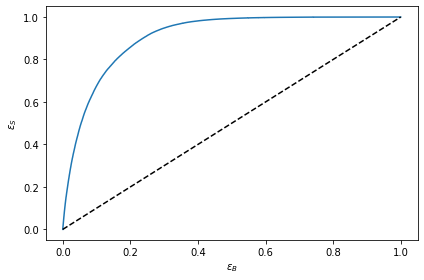

In [19]:
# fpr = epsilon_B, tpr = epsilon_S
fpr, tpr, thresholds = roc_curve(y_true=targs, y_score=preds[:, 1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], ls="--", color="k")
plt.xlabel(r"$\epsilon_B$")
plt.ylabel(r"$\epsilon_S$")
plt.tight_layout()

In [20]:
acc_test = accuracy_score(targs, preds.argmax(dim=-1))
auc_test = auc(fpr, tpr)
print(f"Accuracy: {acc_test:.4f}")
print(f"AUC: {auc_test:.4f}")

Accuracy: 0.8312
AUC: 0.9075


We can see that after one training cycle with 3 epochs, we've reached a test accuracy of ~83%, not bad. Think about how you can improve on this result in your own experimentation.

In [21]:
background_eff = interp1d(tpr, fpr)
background_eff_at_30 = background_eff(0.3)
print(f"Backround rejection at signal efficiency 0.3: {1/background_eff_at_30:0.3f}")

Backround rejection at signal efficiency 0.3: 41.274


In [22]:
def compute_metrics(learn, test_df):
    test_dl = learn.dls.test_dl(test_items=test_df)
    preds, targs = learn.get_preds(dl=test_dl)
    fpr, tpr, _ = roc_curve(y_true=targs, y_score=preds[:, 1])
    acc_test = accuracy_score(targs, preds.argmax(dim=-1))
    auc_test = auc(fpr, tpr)
    background_eff = interp1d(tpr, fpr)
    background_eff_at_30 = background_eff(0.3)

    print(f"Accuracy: {acc_test:.4f}")
    print(f"AUC: {auc_test:.4f}")
    print(
        f"Backround rejection at signal efficiency 0.3: {1/background_eff_at_30:0.3f}"
    )
    return fpr, tpr

In [23]:
fpr_baseline, tpr_baseline = compute_metrics(learn, test_df)

Accuracy: 0.8312
AUC: 0.9075
Backround rejection at signal efficiency 0.3: 41.274


This concludes our short exploration of the use of Deep Neural Networks in particle physics.